<a href="https://colab.research.google.com/github/ejjung312/pytorch-study/blob/main/11_%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5%EB%AA%A8%EB%8D%B8(VGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [15]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [16]:
# GPU 디바이스 할당

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


In [18]:
# 분류 클래스명 정의

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수는 10
n_output = len(classes)

In [19]:
# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
    transforms.Resize(112), # 사전 학습 된 이미지의 화소수 224의 절반인 112를 설정하여 연산량을 줄임
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3,3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [20]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

In [21]:
# 배치 사이즈 지정
batch_size = 50

# 훈련용 데이터로더
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 모델 불러오기

In [22]:
from torchvision import models

net = models.vgg19_bn(pretrained = True)

In [23]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [24]:
# 최종 레이어 함수 확인
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


# 최종 레이어 함수 교체

In [26]:
import numpy as np

torch_seed()

net = models.vgg19_bn(pretrained = True)

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

#### 아래 두줄은 모델의 정확도를 재현하기 위한 작업
# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 사전 학습 모델을 사용한다면 각 레이어 함수의 파라미터는 어느 정도 자리를 잡은 상태이기 때문에
# 복잡한 최적화 함수보다는 간단한 알고리즘이 더 좋음
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

In [27]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00989 acc: 0.83384 val_loss: 0.00358, val_acc: 0.93890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00496 acc: 0.91646 val_loss: 0.00297, val_acc: 0.94950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00375 acc: 0.93556 val_loss: 0.00272, val_acc: 0.95530


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00311 acc: 0.94812 val_loss: 0.00247, val_acc: 0.95950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00260 acc: 0.95510 val_loss: 0.00256, val_acc: 0.96040


초기상태 : 손실 : 0.00358  정확도 : 0.93890
최종상태 : 손실 : 0.00256 정확도 : 0.96040


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

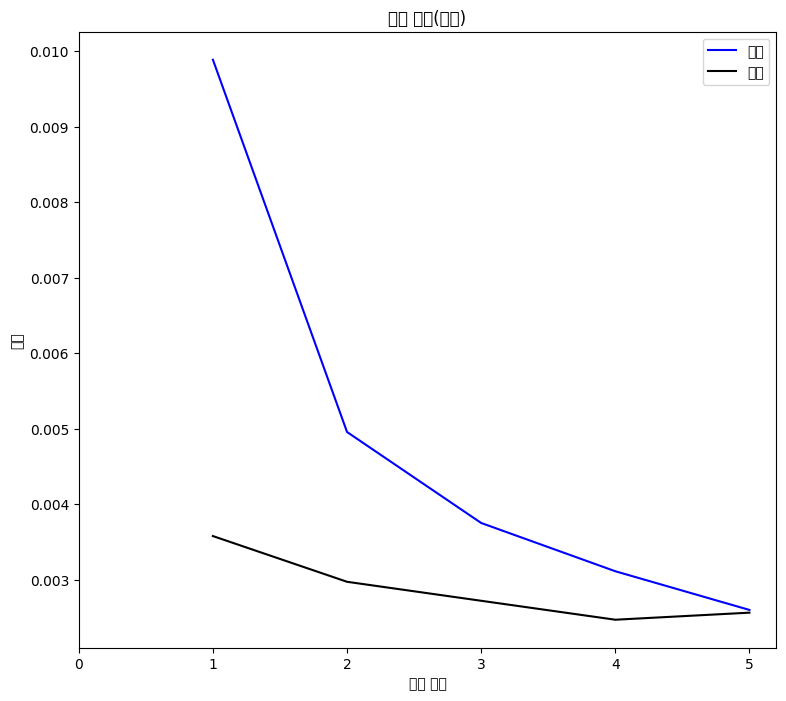

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


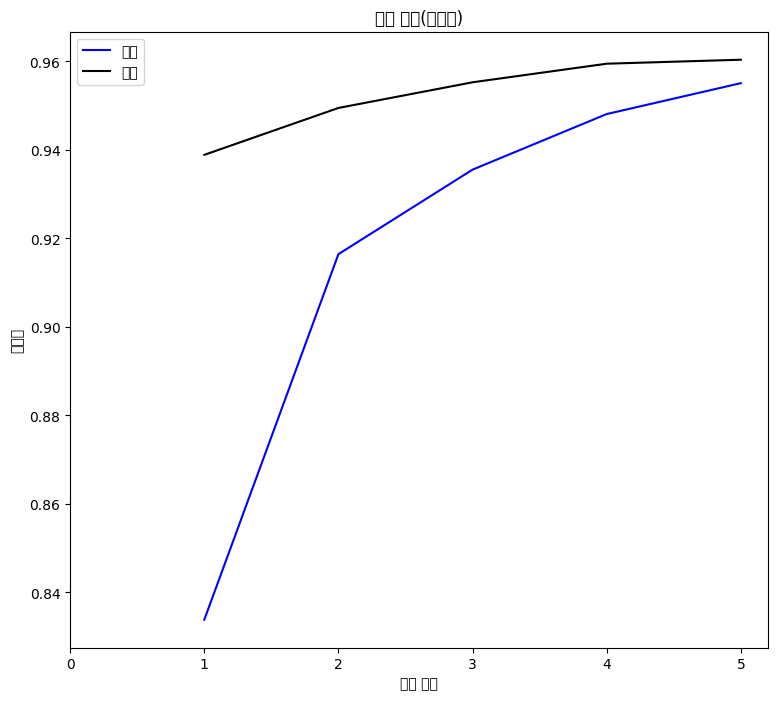

In [28]:
# 결과 요약
evaluate_history(history)

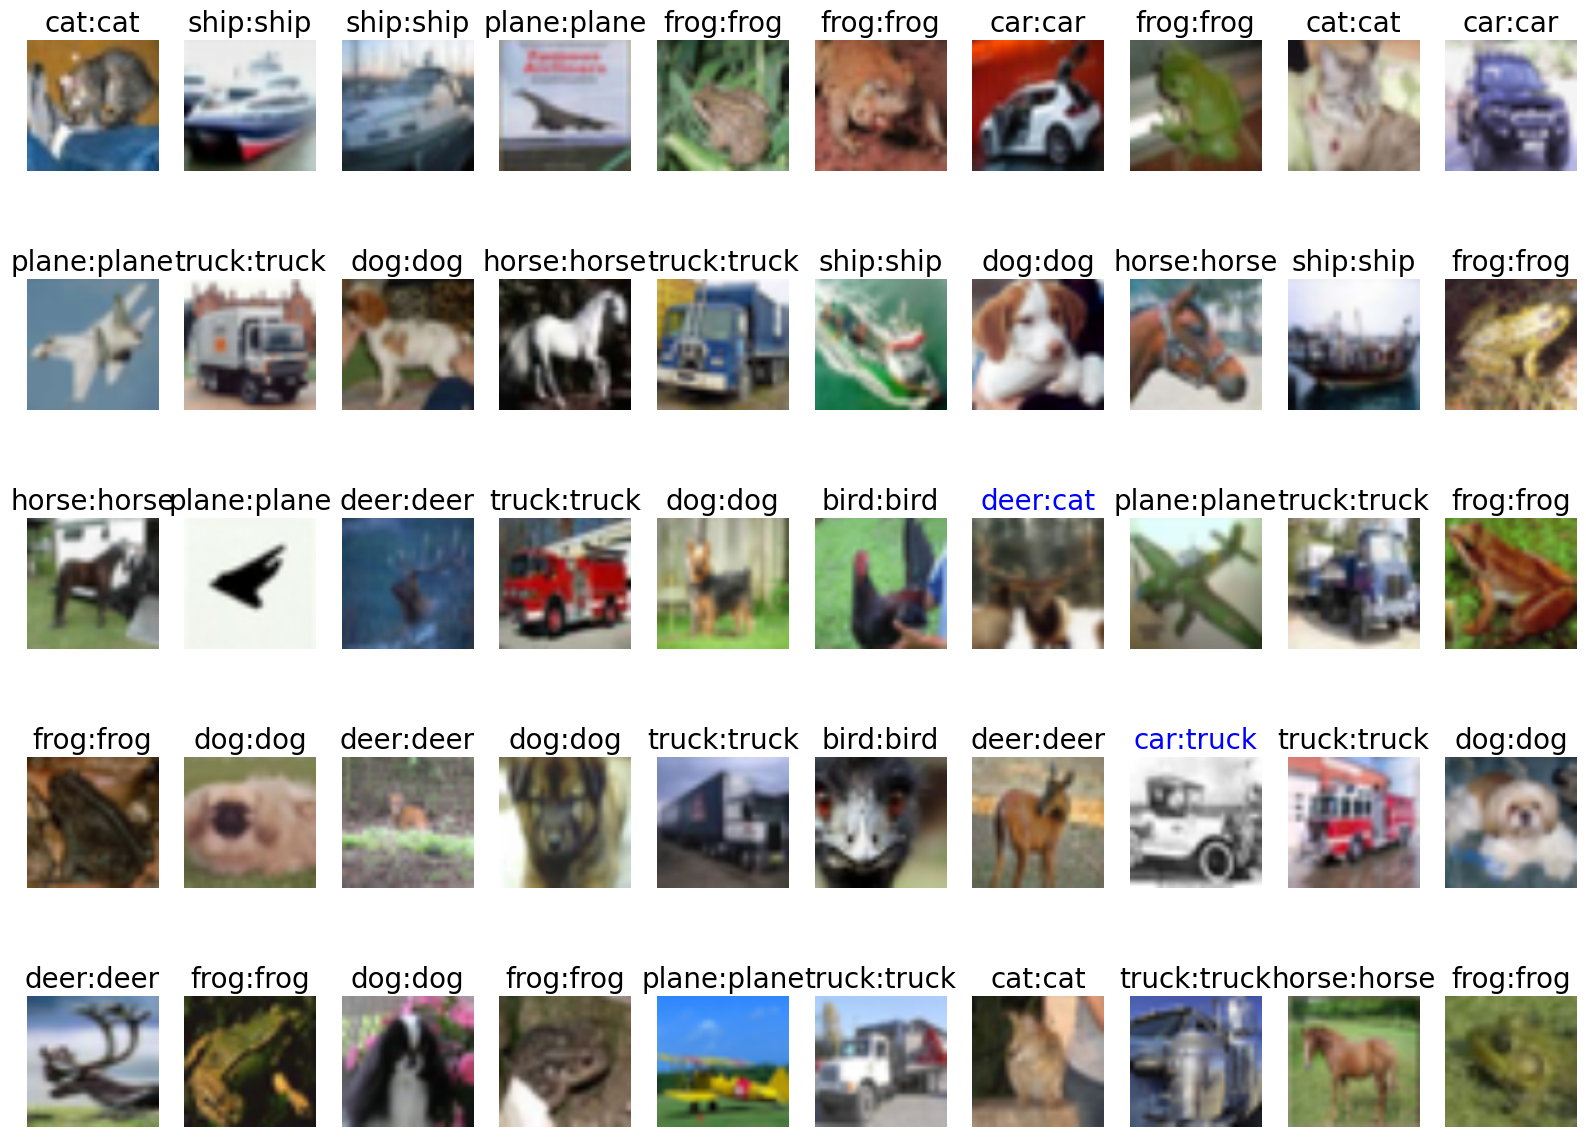

In [29]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)